In [ ]:
from nilearn import plotting
from nilearn import datasets
dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_filename = dataset.maps
labels = dataset.labels
plotting.plot_roi(atlas_filename)



In [ ]:
from nilearn.maskers import NiftiLabelsMasker
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True)
time_series = masker.fit_transform(frmi_files,
                                   confounds=confounds_dataframe)

In [ ]:
#atlas = datasets.fetch_atlas_basc_multiscale_2015(version="sym", resolution=64)
#atlas_filename = datasets.fetch_atlas_yeo_2011()['thick_17']
labels_cortical  = ['Visual', 'Somatosensory', 'Dorsal Attention', 'Ventral Attention', 'Limbic', 'Frontoparietal', 'Default']
from nilearn import plotting
#plotting.plot_roi(atlas_filename)
difumo_names = pd.read_csv(r"C:\Users\Dylan\Desktop\UM_Bsc_neurocog\E22\Projet_Ivado_rainvillelab\connectivity_project\resting_state_hypnosis\atlases\atlas_difumo64\labels_64_dictionary.csv")["Difumo_names"]
print(difumo_names)

>## Load data and get timeseries

In [ ]:
from nilearn.maskers import NiftiMapsMasker, NiftiLabelsMasker, MultiNiftiLabelsMasker, MultiNiftiMapsMasker
import func
import main_con 
import importlib
importlib.reload(main_con)

p = r'E:\Users\Dylan\Desktop\UdeM_H22\E_PSY3008\data_desmartaux\HYPNOSIS_ASL_DATA'
data = func.load_data(p)
#idcs = [i + 1 for i in range(0,len(data.subjects))]
conditions = ['pre_hyp', 'post_hyp', 'diff']
pre_data = data.pre_hyp
post_data = data.post_hyp
results = main_con.con_matrix(p, atlas_name='difumo64', atlas_type='maps', connectivity_measure='precision', verbose=False)

results.keys()


># Stats model on connectomes

In [3]:
import pandas as pd
import os
import glob as glob
import statsmodels.api as sm
from sklearn import preprocessing
import numpy as np
import func
from nilearn.maskers import NiftiMapsMasker, NiftiLabelsMasker, NiftiMasker

ModuleNotFoundError: No module named 'func'

In [5]:
def get_features(res_path, folder):
    path = glob.glob(os.path.join(res_path, folder, 'features*'))
    features = dict()
    keys = ['pre', 'post', 'contrast']
    for p, key in zip(path,keys):
        features[key] = np.load(p, allow_pickle=True)
    return features

# Difumo with precision estimation

In [6]:
save_to = r'C:\Users\Dylan\Desktop\UM_Bsc_neurocog\E22\Projet_Ivado_rainvillelab\results\test_connec' 
f = r'Hypnosis_variables_20190114_pr_jc.xlsx'
res_path = r'C:\Users\Dylan\Desktop\UM_Bsc_neurocog\E22\Projet_Ivado_rainvillelab\results\results_con'
xlsx_path = r'C:\Users\Dylan\Desktop\UM_Bsc_neurocog\E22\Projet_Ivado_rainvillelab\results\Hypnosis_variables_20190114_pr_jc.xlsx'
folder = 'difumo64_precision'

results = dict(pre_series = list(), post_series =  list())
rawY = pd.read_excel(xlsx_path, sheet_name=0, index_col=1, header=2).iloc[2:, [19, 39, 48, 67]]
rawY.columns= ["Abs_chge_pain_hypAna", "Chge_hypnotic_depth", "Mental_relax_absChange", "Abs_diff_automaticity"]
cutY = rawY.drop(['APM04*']).iloc[:-6,:] # remove sub04 and last 6 rows
Y = cutY.fillna(cutY.astype(float).mean()).astype(float)

# X features
dict_features = get_features(res_path,folder)
print('Loaded Pre/post/contrast feature matrices of shape (N, (64*64-64)/2) :\n', [dict_features[key].shape for key in dict_features])
# rename sub
#rename_sub = [f'APM{num}' for num in [sub[4:6] for sub in data.subjects]] # Will rename 'APM_01_H1' with 'APM01'
#idcs = [idcs for idcs, index in enumerate(full_y.index) if index in rename_sub]


Loaded Pre/post/contrast feature matrices of shape (N, (64*64-64)/2) :
 [(31, 2016), (31, 2016), (31, 2016)]


>## Classification of pre / post / contrast conditions

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import PredictionErrorDisplay
def plot_pred(y,y_pred):
    fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
    PredictionErrorDisplay.from_predictions(
        y,
        y_pred=y_pred,
        kind="actual_vs_predicted",
        subsample=100,
        ax=axs[0],
        random_state=0,
    )
    axs[0].set_title("Actual vs. Predicted values")
    PredictionErrorDisplay.from_predictions(
        y,
        y_pred=y_pred,
        kind="residual_vs_predicted",
        subsample=100,
        ax=axs[1],
        random_state=0,
    )
    axs[1].set_title("Residuals vs. Predicted Values")
    fig.suptitle("Plotting cross-validated predictions")
    plt.tight_layout()
    plt.show()

In [ ]:
# Classification of pre/post
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import  ShuffleSplit, train_test_split,cross_val_score, cross_val_predict, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score

x1 = dict_features['post']
x2 = dict_features['pre']
x3 = dict_features['contrast']
binary = False
if binary:
        y_cond = np.concatenate((np.zeros(x1.shape[0]), np.ones(x2.shape[0])),axis=0)
        X = np.concatenate((x1, x2), axis=0)
else:
        y_cond = np.concatenate((np.zeros(x1.shape[0]), np.ones(x2.shape[0]), np.full(x3.shape[0], 2)),axis=0)
        X = np.concatenate((x1, x2, x3), axis=0)
print('X.shape :', X.shape, 'y.shape :', y_cond.shape)
pca = True
if pca:
        clf1 = make_pipeline(StandardScaler(),PCA(n_components=0.80), LogisticRegression(max_iter = 100))
        clf2 = make_pipeline(StandardScaler(),PCA(n_components=0.80), KNeighborsClassifier()) #RandomForestClassifier(n_estimators=50))
        clf3 = make_pipeline(StandardScaler(),PCA(n_components=0.80), SVC(kernel = 'linear',gamma='auto', probability=True))
        
else:
        # Without PCA
        clf1 = make_pipeline(StandardScaler(), LogisticRegression())
        clf2 = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100))
        clf3 = make_pipeline(StandardScaler(), SVC(kernel = 'linear',gamma='auto', probability=True))

eclf = VotingClassifier(estimators=[
        ('lr', clf1), ('rf', clf2), ('svc', clf3)],
        voting='hard')

ss = ShuffleSplit(n_splits=5, test_size=0.25)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
print('Ensemble clf cross val. scores :', cross_val_score(eclf, X, y_cond, cv=ss))

# Logistic regression
X_train, X_test, y_train, y_test = train_test_split(X,y_cond, test_size=0.3, random_state=3)
clf1.fit(X_train, y_train)
print('LogisticRegression cross val. scores :', cross_val_score(clf1, X, y_cond, cv=ss))

#SVC
X_train, X_test, y_train, y_test = train_test_split(X,y_cond, test_size=0.3, random_state=3)
clf3.fit(X_train, y_train)     
#print(clf3.score(X_test, y_test))
print('SVC cross val scores :', cross_val_score(clf3, X, y_cond, cv=ss))

# Confusion matrix with SVC
model = clf3
conf_matrix_list = []
acc = []
for train_index, test_index in ss.split(X, y_cond):

   X_train, X_test = X[train_index], X[test_index]
   y_train, y_test = y_cond[train_index], y_cond[test_index]

   model.fit(X_train, y_train)
   acc.append(accuracy_score(y_test, model.predict(X_test)))
   conf_matrix = confusion_matrix(y_test, model.predict(X_test))
   conf_matrix_list.append(conf_matrix)
print(["{:.2f}%".format(acc[i]) for i in range (len(acc))])
print('Mean SVC confusion matrix :\n', np.mean(conf_matrix_list, axis=0))
disp = ConfusionMatrixDisplay(confusion_matrix=np.mean(conf_matrix_list, axis=0),display_labels=['post', 'pre', 'contrast'])
#disp.set_title('Mean SVC shufflesplit(5 iter)')

disp.plot( cmap=plt.cm.Blues)

>### Dimensionality reduction

In [ ]:

X = dict_features['contrast']
X = 
print(X.shape)

from sklearn.decomposition import PCA
pca = PCA(n_components=0.80)
pca.fit(X)
#print(pca.explained_variance_ratio_)
#print(pca.singular_values_) 
x_pca = pca.transform(X)
print(X.shape, x_pca.shape)

## Regression models

In [2]:
from sklearn import datasets, linear_model
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, ShuffleSplit
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.stats.multitest import fdrcorrection   

y_col = ["Abs_chge_pain_hypAna", "Chge_hypnotic_depth", "Mental_relax_absChange", "Abs_diff_automaticity"]
x = x_pca

for col in y_col:
    
    y = np.array(Y[[col]]).reshape(-1)
    y = preprocessing.normalize(y.reshape(-1, 1),axis=0).reshape(-1)
    print(y.shape)
    #y_log = np.log(y)

    # Models
    lin_reg = sm.OLS(y, sm.add_constant(x)).fit()
    #lin_reg_log = sm.OLS(y_log, x_constant).fit()
    lin_reg_wls = sm.WLS(y, sm.add_constant(x)).fit()
    #lin_reg_wls_log = sm.WLS(y_log, x_constant).fit()

    from scipy.stats.mstats import winsorize
    #win_data = winsorize(np.array(data), limits=[0.05, 0.05])
    #win_reg_lin = sm.OLS(y_norm, win_data).fit() 

    ols_res = lin_reg.summary()
    print(col, '\n-----------',ols_res)
    corr_ps = fdrcorrection(lin_reg.pvalues)[0]
    for i in range(len(corr_ps)):
        if corr_ps[i] == True:
            print('Feature', i, 'is significant with FDR correction')
     
    import func
    # (Ŷi,Yi) plot [0] and (Ŷi , error estimate Ê ) plot at [1]
    glm_func.linearity_test(lin_reg, y)
    
    # resid/Vis. for each feature
    #for i in range(sm.add_constant(x).shape[1]):
        #x_constant = pd.DataFrame(sm.add_constant(x))
        #glm_func.resid_vi(x_constant.iloc[:,i],resids, x_constant.columns[i])   

    #plt.hist(resids)
    #plt.show()
    #func.linearity_test(lin_reg_log, data[yname])
    #func.linearity_test(win_reg_lin, data[yname])
# Stat. test
    model = SVR()
    ss = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
    print(cross_val_score(model, x, y, cv=ss))

        


ModuleNotFoundError: No module named 'glm_func'

In [ ]:
import statsmodels.api as sm
from sklearn import preprocessing
import numpy as np
yname = 'automaticity'
cut_y_auto = y_auto['Unnamed: 68'].iloc[2:-6]
y_auto.drop([5],inplace=True) # drop sub04

y = y_auto.fillna(y_auto.astype(float).mean()).astype(float)
# Normalize 
y_norm = preprocessing.normalize(np.array(y).reshape(-1,1),axis=0)

#y_log = np.log(y)

x = data_contrast
x_constant = sm.add_constant(x)

# Models
lin_reg = sm.OLS(y_norm, x_constant).fit()
#lin_reg_log = sm.OLS(y_log, x_constant).fit()
lin_reg_wls = sm.WLS(y, x_constant).fit()
#lin_reg_wls_log = sm.WLS(y_log, x_constant).fit()

from scipy.stats.mstats import winsorize
win_data = winsorize(np.array(data), limits=[0.05, 0.05])
#win_reg_lin = sm.OLS(y_norm, win_data).fit() 

ols_res = lin_reg.summary()
print(ols_res)pi

In [ ]:
coordinates = plotting.find_parcellation_cut_coords(labels_img=atlas_filename)


In [ ]:
plotting.plot_connectome(
    mean_correlation_matrix,
    coordinates,
    edge_threshold="10%",
    title="yeo (func)",
)

## *Visualization of Atlases, connectomes and connectivity matrix*

In [ ]:
import os
import pandas as pd
import numpy as np
import func 
import glob
import numpy as np
import nibabel as nib
from nilearn.maskers import NiftiMapsMasker, NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
import func
from nilearn import datasets, plotting, image
from nilearn.regions import connected_label_regions
from nilearn.plotting import plot_matrix, find_probabilistic_atlas_cut_coords


>## Pre, post, contrast with yeo 14 ROIs bilateral

In [ ]:
atlas, labels, _ = func.load_choose_atlas('yeo_7', bilat=True)

title = 'Post-pre (Z; 99%; Correlation; yeo7)'
#view = plotting.view_connectome(results['zcontrast_mean_connectome'], find_probabilistic_atlas_cut_coords(atlas),edge_threshold="99%", title = title)

p = r'C:\Users\Dylan\Desktop\UM_Bsc_neurocog\E22\Projet_Ivado_rainvillelab\results\results_con\yeo7_correlation\contrast_mean_connectome.npy'
view = plotting.view_connectome(np.load(p), find_probabilistic_atlas_cut_coords(atlas),edge_threshold=None, title = title)

# In a Jupyter notebook, if ``view`` is the output of a cell, it will
# be displayed below the cell
view

In [ ]:
p = r'C:\Users\Dylan\Desktop\UM_Bsc_neurocog\E22\Projet_Ivado_rainvillelab\results\results_con\difumo64_precision\contrast_mean_connectome.npy'
view = plotting.view_connectome(np.load(p), find_probabilistic_atlas_cut_coords(atlas),edge_threshold="99%", title = title)
view

In [ ]:
np.unique(results['zcontrast_mean_connectome'], return_counts=True)

In [ ]:
import func 
import importlib
importlib.reload(func) 

root = r'C:\Users\Dylan\Desktop\UM_Bsc_neurocog\E22\Projet_Ivado_rainvillelab\results\results_con'
atlas_name = 'Yeo_14_bilateral '
atlas, labels, _ = func.load_choose_atlas('yeo_7', bilat=True)
func.out(root,'yeo7_precision', list(labels), atlas, atlas_name,conditions = ['Pre-Hyp', 'Post-Hyp', 'Post-pre'], mask_bilat = True, plot_con = True, con_tresh = '90%')


In [ ]:
import matplotlib.pyplot as plt

for time_serie, label in zip(time_series.T, labels):
    plt.plot(time_serie, label=label)

plt.title("Default Mode Network Time Series")
plt.xlabel("Scan number")
plt.ylabel("Normalized signal")
plt.legend()
plt.tight_layout()

>## Comparison of different covariance estimators for yeo 14

In [ ]:
np.concatenate(results['pre_series']).shape

In [ ]:
import importlib
importlib.reload(func) 

# Load timeseries

print([ts.shape for ts in results["pre_series"]])
print([ts.shape for ts in results["post_series"]])

func.graphLasso_covariance_estim(results['pre_series'],cond = 'Pre-Hyp', atlas_name = 'yeo_7', tresh='90%')
print('-------------------')
func.graphLasso_covariance_estim(results['post_series'],cond = 'Post-Hyp', atlas_name = 'yeo_7', tresh='90%')

>## Pre, post and contrast for DiFuMo 64

In [ ]:
print(results.keys())
filt_labels = []
for row in results['zcontrast_mean_connectome']:
    for idx, val in enumerate(row):
        if val >2:
            filt_labels.append(labels[idx])
print(pd.DataFrame(filt_labels))

In [ ]:
from scripts import func 
import importlib
importlib.reload(func) 

root = r'C:\Users\Dylan\Desktop\UM_Bsc_neurocog\E22\Projet_Ivado_rainvillelab\results\results_con'
atlas_name = 'difumo64'
atlas, labels,_, confounds = func.load_choose_atlas(atlas_name, bilat=False)
func.out(root,'difumo64_correlation', list(labels), atlas,atlas_name, conditions = ['Pre-Hyp', 'Post-Hyp', 'Post-pre'], con_tresh = '98%',mask_bilat = True)

## Correlation estimation

Loading atlas:  difumo64
plotting probabilistic connectome


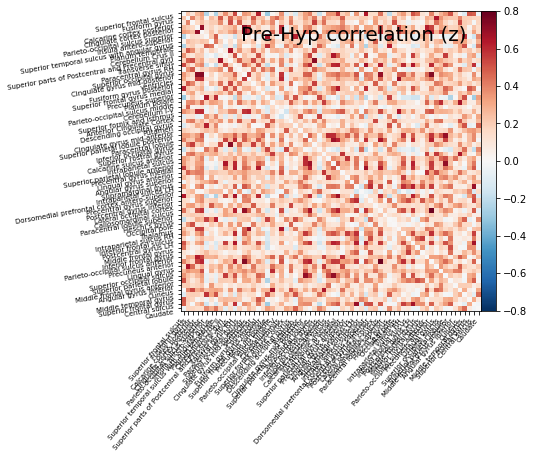

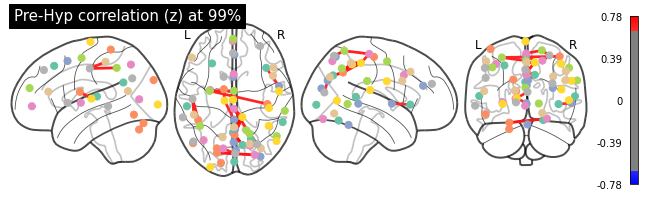

plotting probabilistic connectome


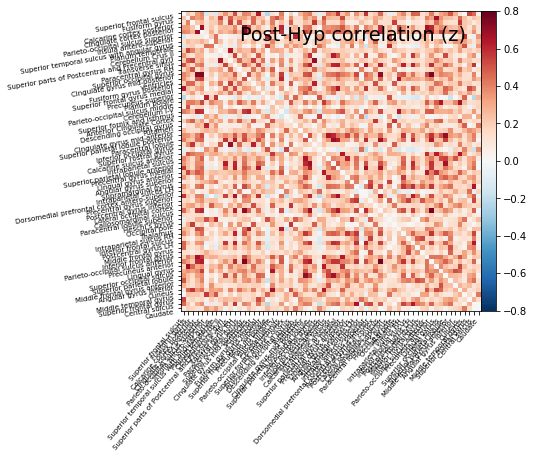

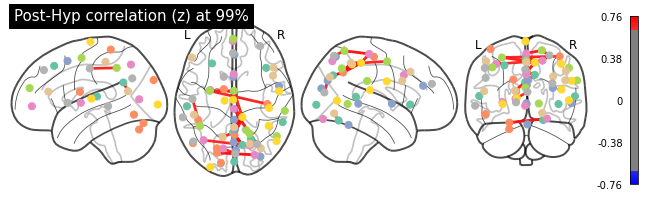

plotting probabilistic connectome


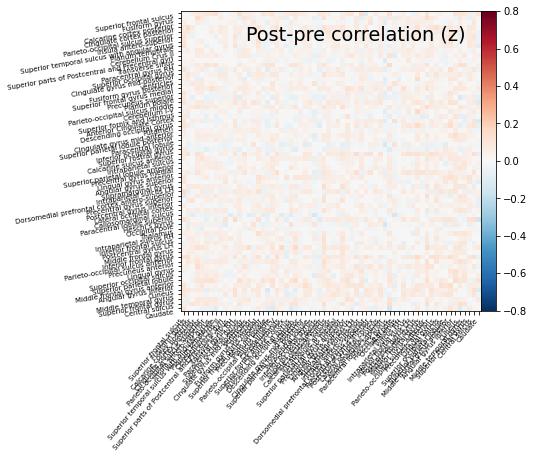

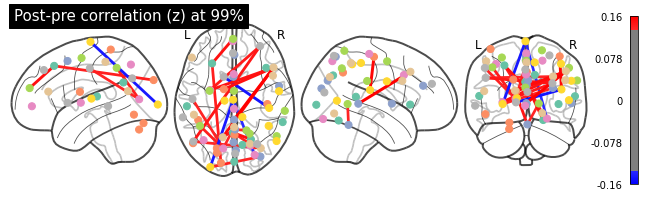

In [1]:
from scripts import func 
import importlib
importlib.reload(func) 

root = r'C:\Users\Dylan\Desktop\UM_Bsc_neurocog\E22\Projet_Ivado_rainvillelab\results\results_con'
atlas_name = 'difumo64'
atlas, labels,_, confounds = func.load_choose_atlas(atlas_name, bilat=False)
func.out(root,'difumo64_correlation', list(labels), atlas,atlas_name, conditions = ['Pre-Hyp', 'Post-Hyp', 'Post-pre'],cov_estim = 'correlation (z)', con_tresh = '99%',mask_bilat = True)

## Precision estimation

Loading atlas:  difumo64
plotting probabilistic connectome


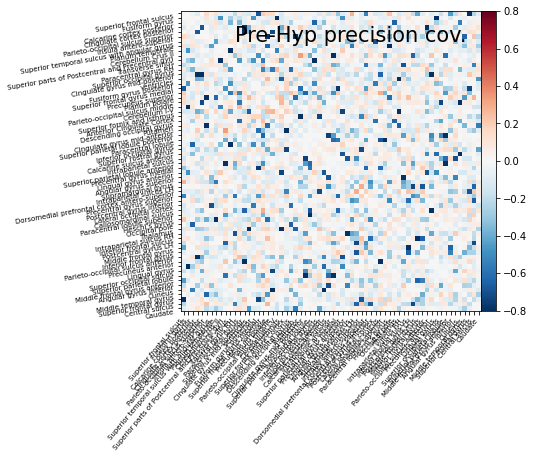

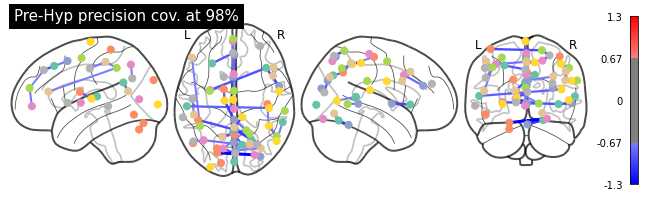

plotting probabilistic connectome


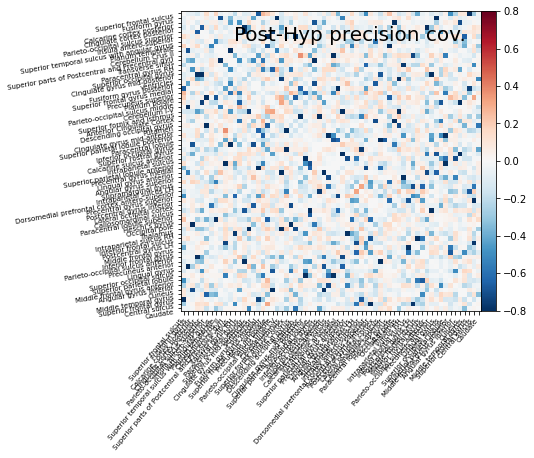

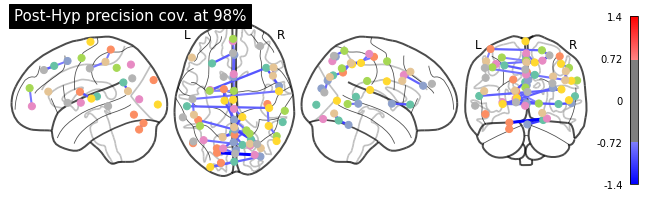

plotting probabilistic connectome


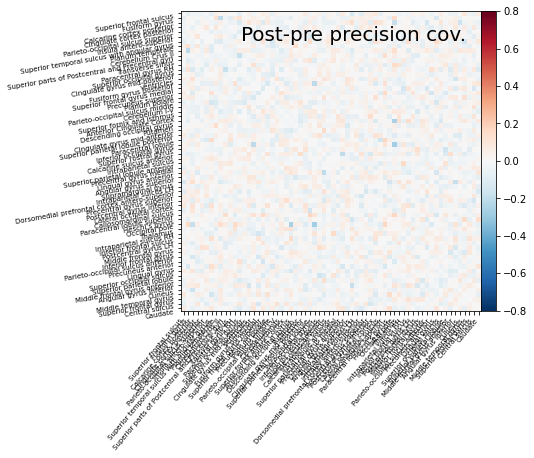

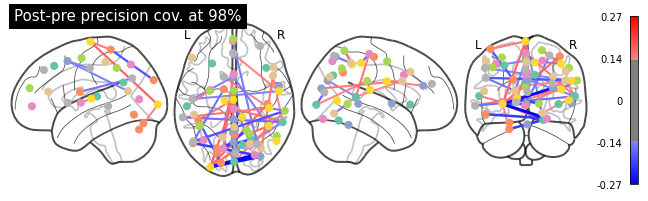

In [1]:
from scripts import func 
import importlib
importlib.reload(func) 

root = r'C:\Users\Dylan\Desktop\UM_Bsc_neurocog\E22\Projet_Ivado_rainvillelab\results\results_con'
atlas_name = 'difumo64'
atlas, labels,_, confounds = func.load_choose_atlas(atlas_name, bilat=False)
func.out(root,'difumo64_precision', list(labels), atlas,atlas_name, conditions = ['Pre-Hyp', 'Post-Hyp', 'Post-pre'],cov_estim = 'precision cov.', con_tresh = '98%',mask_bilat = True)


### Plot timeseries from ROIs

In [ ]:
import matplotlib.pyplot as plt

atlas, labels, _ = func.load_choose_atlas('yeo_7', bilat=True)

for time_serie, label in zip(np.array(results["pre_series"]).mean(axis=0).T, labels):
    plt.plot(time_serie, label=label)

    plt.title("Default Mode Network Time Series")
    plt.xlabel("Scan number")
    plt.ylabel("Normalized signal")
    
    plt.legend()
    plt.tight_layout()

## Scale comparison

difumo precision difumo correlation in  // standardize="zscore_sample" //  "psc" // 

In [ ]:
res_path = r'C:\Users\Dylan\Desktop\UM_Bsc_neurocog\E22\Projet_Ivado_rainvillelab\results\results_con'

folder = 'difumo64_precision'



In [ ]:
# connectivity data linear model
p1 = r'C:\Users\Dylan\Desktop\UM_Bsc_neurocog\E22\Projet_Ivado_rainvillelab\results\partial_connect_hyp_yeo17thick'
data_pre = np.load(os.path.join(p1, 'features_pre.npy'))
data_post = np.load(os.path.join(p1, 'features_post.npy'))
data_contrast = np.load(os.path.join(p1, 'features_contrast.npy'))
#fully_auto = pd.read_csv(os.path.join(p1, 'Y.csv'))

pre_mean17 = np.load(os.path.join(p1, 'pre_hyp_mean_connectome.npy'))
post_mean17 = np.load(os.path.join(p1, 'post_hyp_mean_connectome.npy'))
contrast_mean17 = np.load(os.path.join(p1, 'contrast_mean_connectome.npy'))


In [ ]:
p = r'C:\Users\Dylan\Desktop\UM_Bsc_neurocog\E22\Projet_Ivado_rainvillelab\results\results_con\yeo7_correlation'
data_pre = np.load(os.path.join(p, 'features_pre.npy'))
data_post = np.load(os.path.join(p, 'features_post.npy'))
data_contrast = np.load(os.path.join(p, 'features_contrast.npy'))


In [ ]:
pre_mean = np.load(os.path.join(p, 'pre_hyp_mean_connectome.npy'))
post_mean = np.load(os.path.join(p, 'post_hyp_mean_connectome.npy'))
contrast_mean = np.load(os.path.join(p, 'contrast_mean_connectome.npy'))


In [ ]:
labels = ['Visual', 'Somatosensory', 'Dorsal Attention', 'Ventral Attention', 'Limbic', 'Frontoparietal', 'Default']
names = ['pre', 'post', 'contrast']
for i, correlation_matrix in enumerate([pre_mean, post_mean, contrast_mean]):#[results['pre_mean_connetomes'], results['post_mean_connetomes']]:
            np.fill_diagonal(correlation_matrix, 0)
            plotting.plot_matrix(correlation_matrix, labels=labels, colorbar=True, vmax=0.8, vmin=-0.8)
            plot_connectome(correlation_matrix, atlas_filename, names[i])

       

In [ ]:
import statsmodels.api as sm
from sklearn import preprocessing
import numpy as np
yname = 'automaticity'

x = data_contrast
x_constant = sm.add_constant(x)
# Models
lin_reg = sm.OLS(y, x_constant).fit()
lin_reg_wls = sm.WLS(y, x_constant).fit()

from scipy.stats.mstats import winsorize
win_data = winsorize(np.array(data), limits=[0.05, 0.05])
#win_reg_lin = sm.OLS(y_norm, win_data).fit() 

ols_res = lin_reg.summary()
print(ols_res)

In [ ]:
x = data_pre
x_constant = sm.add_constant(x)
# Models
lin_reg = sm.OLS(y, x_constant).fit()
lin_reg_wls = sm.WLS(y, x_constant).fit()

from scipy.stats.mstats import winsorize
win_data = winsorize(np.array(data), limits=[0.05, 0.05])
#win_reg_lin = sm.OLS(y_norm, win_data).fit() 

ols_res = lin_reg.summary()
print(ols_res)

In [ ]:
x

In [ ]:
x = data_post
x_constant = sm.add_constant(x)
# Models
lin_reg = sm.OLS(y, x_constant).fit()
lin_reg_wls = sm.WLS(y, x_constant).fit()

from scipy.stats.mstats import winsorize
win_data = winsorize(np.array(data), limits=[0.05, 0.05])
#win_reg_lin = sm.OLS(y_norm, win_data).fit() 

ols_res = lin_reg.summary()
print(ols_res)

## ridge

In [ ]:
from sklearn.linear_model import Ridge
import numpy as np
X = data_post 

clf = Ridge(alpha=1.0)
clf.fit(X, y)
coefs = clf.coef_

In [ ]:
print(pwd, '\n', atlas_path)
print(os.path.join(pwd, atlas_path))

In [ ]:
import pandas as pd
import nibabel as nib
import os
pwd = os.getcwd()
atlas_path = r'C:\Users\Dylan\Desktop\UM_Bsc_neurocog\E22\Projet_Ivado_rainvillelab\connectivity_project\resting_state_hypnosis\atlases\atlas_difumo64\64difumo2mm_maps.nii.gz'
atlas = nib.load(atlas_path)

atlas_labels = pd.read_csv(r'C:\Users\Dylan\Desktop\UM_Bsc_neurocog\E22\Projet_Ivado_rainvillelab\connectivity_project\resting_state_hypnosis\atlases\atlas_difumo64\labels_64_dictionary.csv')
